In [1]:
# 导入库
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# 提取房屋面积、总价、单价

def extract_area(x):
    # 提取带“㎡”的数字
    match = re.search(r'([\d.]+)\s*㎡', str(x))
    return float(match.group(1)) if match else np.nan

def extract_total_price(x):
    # 提取“万”前的数字
    match = re.search(r'([\d.]+)\s*万', str(x))
    return float(match.group(1)) if match else np.nan

def extraction_apply(df, is_rent):
    # 应用函数
    df['area_clean'] = df['area'].apply(extract_area)
    if is_rent:
        df['total_price_clean'] = df['total_price']
    else:
        df['total_price_clean'] = df['total_price'].apply(extract_total_price) * 10000
    df['unit_price_clean'] = df['total_price_clean'] / df['area_clean']
    return df

In [3]:
# 描述性统计和离群值检测&显示

RENT = 1
NOT_RENT = 0
def describe_df(df):
    # 描述性统计
    desc = df[['area_clean', 'total_price_clean', 'unit_price_clean']].describe()
    print("\n描述性统计结果：")
    display(desc)

def detect_outliers(series):
    # 3σ原则下的离群值检测
    mean = series.mean()
    std = series.std()
    lower = mean - 3 * std
    upper = mean + 3 * std
    outliers = series[(series < lower) | (series > upper)]
    return outliers, lower, upper

def outliers_show(df, location, is_rent):
    # 离群值查找和显示（3-sigma原则）
    mask = pd.Series(True, index=df.index)  # 初始全保留
    
    # 离群值查找和显示（3-sigma原则）
    for col in ['area_clean', 'total_price_clean', 'unit_price_clean']:
        outliers, lower, upper = detect_outliers(df[col].dropna())
        print(f"\n【{col}】离群值检测（3-sigma原则）：")
        print(f"下限：{lower:.2f}, 上限：{upper:.2f}")
        print(f"离群值数量：{len(outliers)}")

    # 更新mask：只保留在 [lower, upper] 范围内的值
        mask &= df[col].between(lower, upper)

    # 可视化离群值
    plt.figure(figsize=(12, 4))
    for i, col in enumerate(['area_clean', 'total_price_clean', 'unit_price_clean'], 1):
        plt.subplot(1, 3, i)
        sns.boxplot(x=df[col], color='skyblue')
        plt.title(col)
    plt.tight_layout()
    plt.show()

    # 保存去除离群值后的数据 ----
    folder_path = "cleaned_data"

    # 检查文件夹是否存在
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)  # 递归创建文件夹
        
    df_no_outliers = df[mask].copy()
    
    if is_rent:
        output_path = './cleaned_data/cleaned_rent_' + location + '.csv'
    else:
        output_path = './cleaned_data/cleaned_price_' + location + '.csv'
    df_no_outliers[['tag', 'area_clean', 'unit_price_clean']].to_csv(output_path, index=False)
    print("\n已保存去除离群值后的数据")


def description_apply(df_buy, df_rent, location):
    # 提取数据
    df_buy = extraction_apply(df_buy, NOT_RENT)
    df_rent = extraction_apply(df_rent, RENT)
    
    # 描述信息
    print('----------' + location + '购房数据描述----------')
    describe_df(df_buy)
    outliers_show(df_buy, location, NOT_RENT)
    
    # 显示并记录中位数
    print('房屋面积中位数: ', df_buy['area_clean'].median())    
    print('房屋总购买价格中位数: ', df_buy['total_price_clean'].median())
    print('房屋单位购买价格中位数: ', df_buy['unit_price_clean'].median().round(2))
    print()
    
    print('----------' + location + '租房数据描述----------')
    describe_df(df_rent)
    outliers_show(df_rent, location, RENT)
    # 显示并记录中位数
    print('房屋面积中位数: ', df_rent['area_clean'].median())    
    print('房屋租赁价格中位数: ', df_rent['total_price_clean'].median())
    print('房屋单位租赁价格中位数: ', df_rent['unit_price_clean'].median().round(2))
    
    return df_buy['unit_price_clean'].median() / df_rent['unit_price_clean'].median()
    

In [4]:
median_dict = {}

----------回龙观购房数据描述----------

描述性统计结果：


,area_clean,total_price_clean,unit_price_clean
count,2863.000000,2.985000e+03,2863.000000
mean,107.605152,4.889488e+06,41671.835270
std,55.721068,3.873792e+06,11732.006382
min,32.210000,8.500000e+05,17384.535547
25%,83.885000,3.300000e+06,32937.840432
50%,98.880000,4.280000e+06,39390.088945
75%,124.780000,5.350000e+06,49677.913694
max,1888.000000,1.100000e+08,141174.054776



【area_clean】离群值检测（3-sigma原则）：
下限：-59.56, 上限：274.77
离群值数量：26

【total_price_clean】离群值检测（3-sigma原则）：
下限：-6731887.01, 上限：16510862.82
离群值数量：46

【unit_price_clean】离群值检测（3-sigma原则）：
下限：6475.82, 上限：76867.85
离群值数量：4


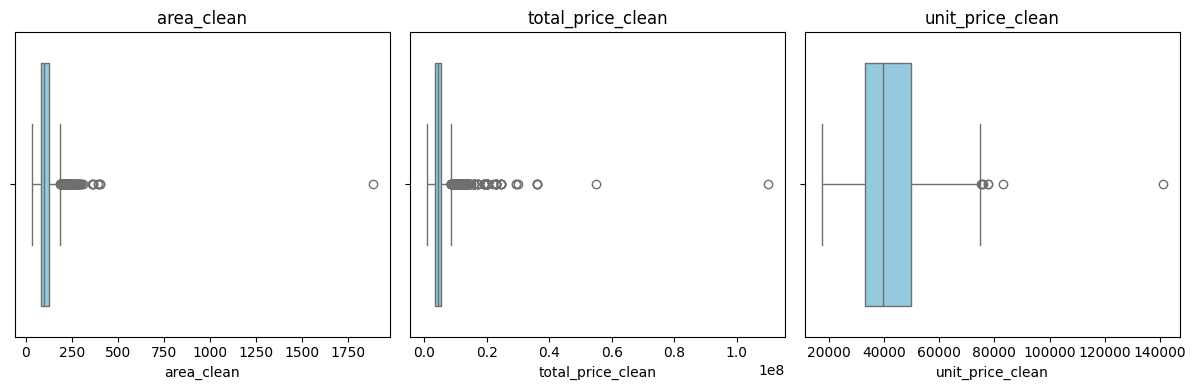


已保存去除离群值后的数据
房屋面积中位数:  98.88
房屋总购买价格中位数:  4280000.0
房屋单位购买价格中位数:  39390.09

----------回龙观租房数据描述----------

描述性统计结果：


,area_clean,total_price_clean,unit_price_clean
count,1440.000000,1440.000000,1440.000000
mean,81.964583,5713.948611,80.802098
std,56.097894,3112.623422,29.415029
min,7.000000,1000.000000,14.634146
25%,51.000000,4500.000000,61.052632
50%,86.000000,5800.000000,74.157303
75%,102.000000,6800.000000,89.915730
max,683.000000,30000.000000,307.142857



【area_clean】离群值检测（3-sigma原则）：
下限：-86.33, 上限：250.26
离群值数量：23

【total_price_clean】离群值检测（3-sigma原则）：
下限：-3623.92, 上限：15051.82
离群值数量：25

【unit_price_clean】离群值检测（3-sigma原则）：
下限：-7.44, 上限：169.05
离群值数量：25


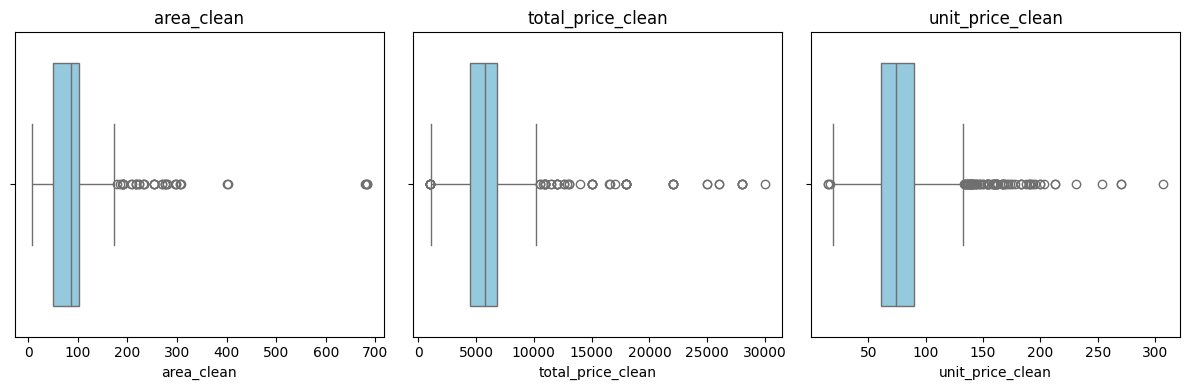


已保存去除离群值后的数据
房屋面积中位数:  86.0
房屋租赁价格中位数:  5800.0
房屋单位租赁价格中位数:  74.16


In [5]:
# 回龙观信息
df_buy = pd.read_csv('./house_price/house_price_huilongguan.csv')
df_rent = pd.read_csv('./house_rent/rent_price_huilongguan.csv')

median_dict['回龙观'] = description_apply(df_buy, df_rent, '回龙观')

----------霍营购房数据描述----------

描述性统计结果：


,area_clean,total_price_clean,unit_price_clean
count,456.000000,4.580000e+02,456.000000
mean,98.085855,4.268701e+06,42398.078311
std,41.243079,2.418024e+06,9723.492092
min,34.840000,6.600000e+05,16509.042641
25%,71.560000,2.700000e+06,36174.542166
50%,88.710000,3.510000e+06,40673.528135
75%,111.000000,5.110000e+06,47723.083024
max,303.830000,1.699000e+07,67651.509118



【area_clean】离群值检测（3-sigma原则）：
下限：-25.64, 上限：221.82
离群值数量：9

【total_price_clean】离群值检测（3-sigma原则）：
下限：-2985370.67, 上限：11522772.42
离群值数量：11

【unit_price_clean】离群值检测（3-sigma原则）：
下限：13227.60, 上限：71568.55
离群值数量：0


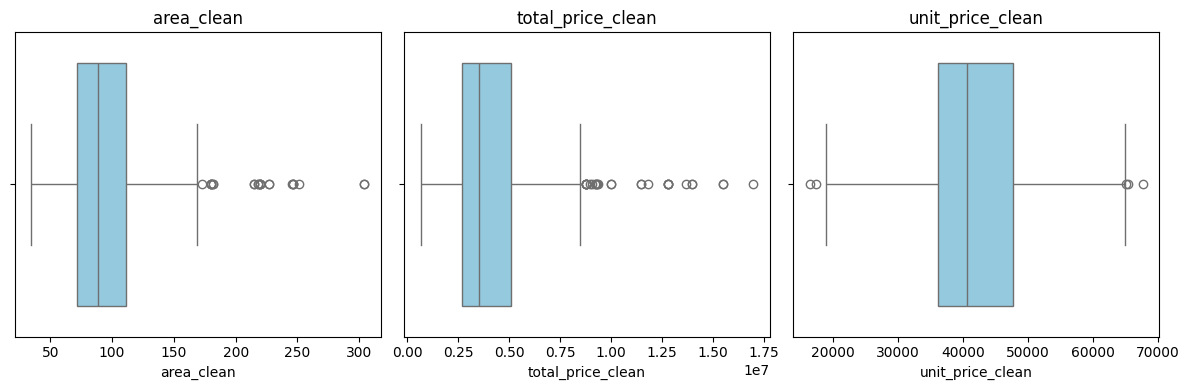


已保存去除离群值后的数据
房屋面积中位数:  88.71000000000001
房屋总购买价格中位数:  3510000.0
房屋单位购买价格中位数:  40673.53

----------霍营租房数据描述----------

描述性统计结果：


,area_clean,total_price_clean,unit_price_clean
count,642.000000,642.000000,642.000000
mean,68.993769,4967.861371,81.062601
std,32.009797,1839.627859,27.312426
min,6.000000,1000.000000,13.138686
25%,50.000000,4400.000000,65.232488
50%,73.000000,5200.000000,72.602740
75%,89.000000,5900.000000,90.183824
max,174.000000,16000.000000,300.000000



【area_clean】离群值检测（3-sigma原则）：
下限：-27.04, 上限：165.02
离群值数量：3

【total_price_clean】离群值检测（3-sigma原则）：
下限：-551.02, 上限：10486.74
离群值数量：7

【unit_price_clean】离群值检测（3-sigma原则）：
下限：-0.87, 上限：163.00
离群值数量：11


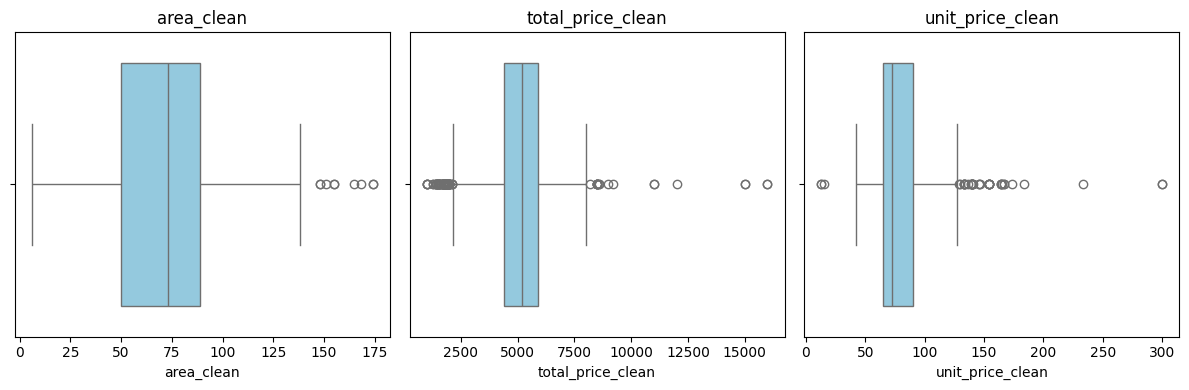


已保存去除离群值后的数据
房屋面积中位数:  73.0
房屋租赁价格中位数:  5200.0
房屋单位租赁价格中位数:  72.6


In [6]:
# 霍营信息
df_buy = pd.read_csv('./house_price/house_price_huoying.csv')
df_rent = pd.read_csv('./house_rent/rent_price_huoying.csv')

median_dict['霍营'] = description_apply(df_buy, df_rent, '霍营')

----------沙河购房数据描述----------

描述性统计结果：


,area_clean,total_price_clean,unit_price_clean
count,1635.000000,2.513000e+03,1635.000000
mean,122.014550,1.500526e+07,37854.107809
std,126.661822,2.028222e+07,12748.767331
min,18.000000,2.300000e+05,11440.579033
25%,66.000000,2.600000e+06,31265.147843
50%,85.960000,4.600000e+06,36078.098472
75%,121.940000,2.200000e+07,41905.344282
max,1022.280000,1.800000e+08,156512.892750



【area_clean】离群值检测（3-sigma原则）：
下限：-257.97, 上限：502.00
离群值数量：44

【total_price_clean】离群值检测（3-sigma原则）：
下限：-45841389.15, 上限：75851907.81
离群值数量：39

【unit_price_clean】离群值检测（3-sigma原则）：
下限：-392.19, 上限：76100.41
离群值数量：26


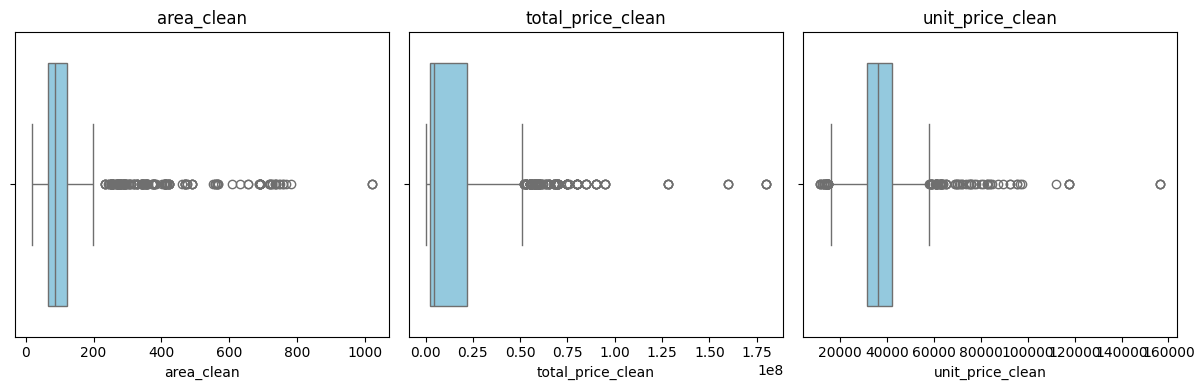


已保存去除离群值后的数据
房屋面积中位数:  85.96
房屋总购买价格中位数:  4600000.0
房屋单位购买价格中位数:  36078.1

----------沙河租房数据描述----------

描述性统计结果：


,area_clean,total_price_clean,unit_price_clean
count,2126.000000,2126.000000,2126.000000
mean,104.714958,5463.782690,56.922095
std,248.175728,8309.873088,19.908610
min,8.000000,800.000000,1.031250
25%,60.000000,3107.500000,45.882353
50%,81.000000,3900.000000,52.800000
75%,90.000000,4500.000000,62.500000
max,6892.000000,120000.000000,194.444444



【area_clean】离群值检测（3-sigma原则）：
下限：-639.81, 上限：849.24
离群值数量：9

【total_price_clean】离群值检测（3-sigma原则）：
下限：-19465.84, 上限：30393.40
离群值数量：42

【unit_price_clean】离群值检测（3-sigma原则）：
下限：-2.80, 上限：116.65
离群值数量：57


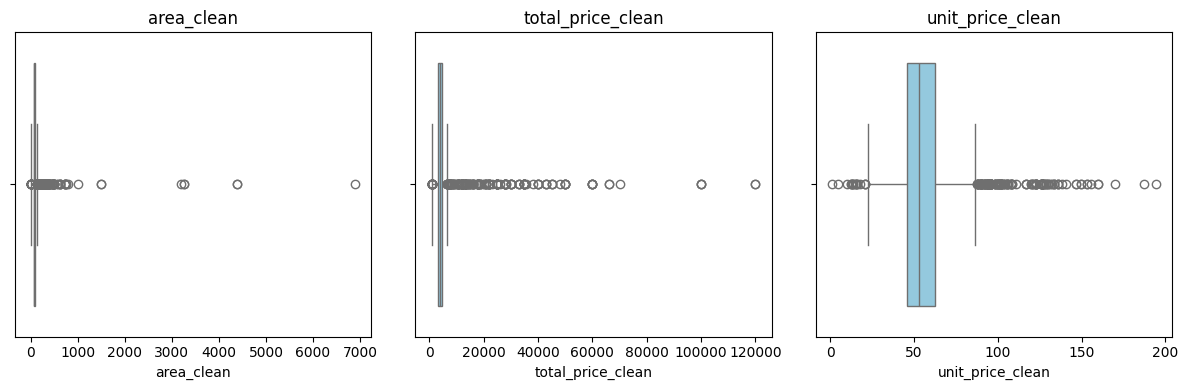


已保存去除离群值后的数据
房屋面积中位数:  81.0
房屋租赁价格中位数:  3900.0
房屋单位租赁价格中位数:  52.8


In [7]:
# 沙河信息
df_buy = pd.read_csv('./house_price/house_price_shahe.csv')
df_rent = pd.read_csv('./house_rent/rent_price_shahe.csv')

median_dict['沙河'] = description_apply(df_buy, df_rent, '沙河')

----------天通苑购房数据描述----------

描述性统计结果：


,area_clean,total_price_clean,unit_price_clean
count,2506.000000,2.530000e+03,2506.000000
mean,140.417809,4.547849e+06,32536.207508
std,52.829908,2.207189e+06,7403.347800
min,45.010000,1.260000e+06,16671.812288
25%,100.960000,3.230000e+06,27912.927122
50%,131.390000,4.080000e+06,31579.122398
75%,164.880000,5.150000e+06,36295.369212
max,548.700000,2.880000e+07,92443.987931



【area_clean】离群值检测（3-sigma原则）：
下限：-18.07, 上限：298.91
离群值数量：34

【total_price_clean】离群值检测（3-sigma原则）：
下限：-2073718.74, 上限：11169415.97
离群值数量：40

【unit_price_clean】离群值检测（3-sigma原则）：
下限：10326.16, 上限：54746.25
离群值数量：21


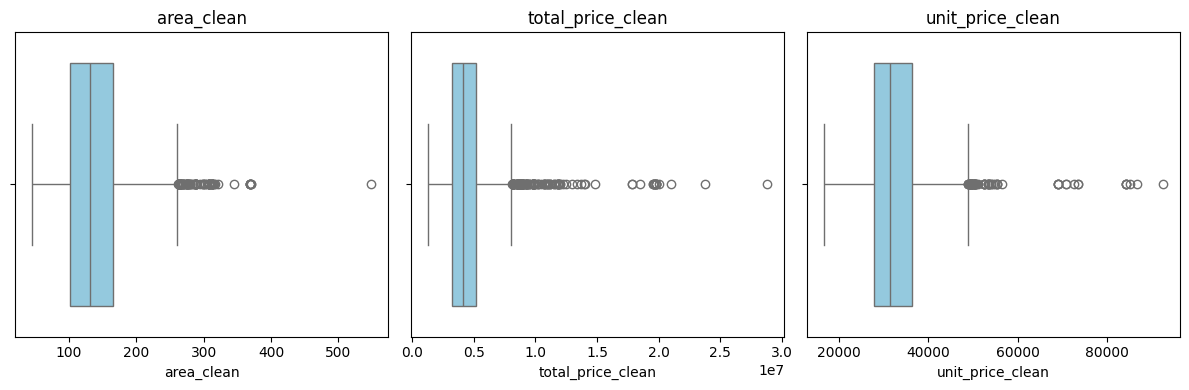


已保存去除离群值后的数据
房屋面积中位数:  131.39
房屋总购买价格中位数:  4080000.0
房屋单位购买价格中位数:  31579.12

----------天通苑租房数据描述----------

描述性统计结果：


,area_clean,total_price_clean,unit_price_clean
count,1704.000000,1704.000000,1704.000000
mean,83.312793,4946.322183,73.833094
std,51.042774,2538.589121,34.187832
min,6.000000,1000.000000,13.422819
25%,30.000000,2650.000000,53.731343
50%,90.000000,5200.000000,61.451047
75%,110.000000,6000.000000,85.426136
max,400.000000,25000.000000,308.333333



【area_clean】离群值检测（3-sigma原则）：
下限：-69.82, 上限：236.44
离群值数量：13

【total_price_clean】离群值检测（3-sigma原则）：
下限：-2669.45, 上限：12562.09
离群值数量：26

【unit_price_clean】离群值检测（3-sigma原则）：
下限：-28.73, 上限：176.40
离群值数量：34


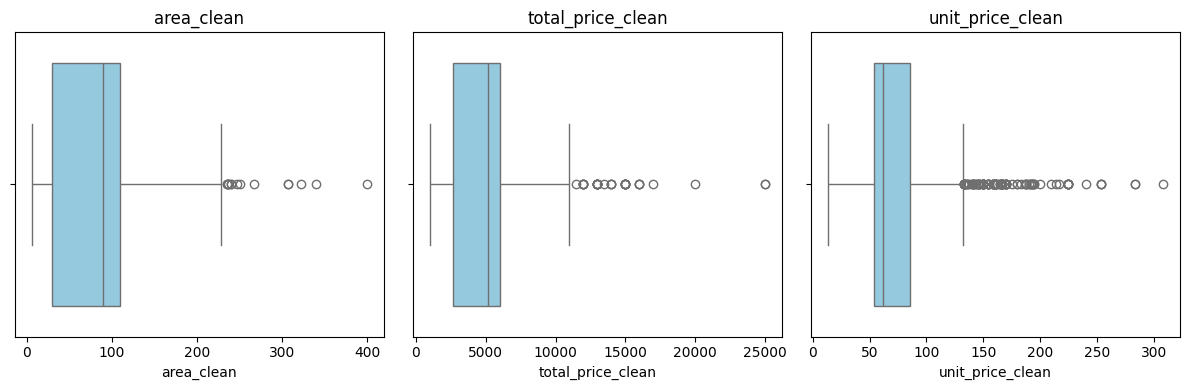


已保存去除离群值后的数据
房屋面积中位数:  90.0
房屋租赁价格中位数:  5200.0
房屋单位租赁价格中位数:  61.45


In [8]:
# 天通苑信息
df_buy = pd.read_csv('./house_price/house_price_tiantongyuan.csv')
df_rent = pd.read_csv('./house_rent/rent_price_tiantongyuan.csv')

median_dict['天通苑'] = description_apply(df_buy, df_rent, '天通苑')

回龙观 中位数: 531.17
霍营 中位数: 560.22
沙河 中位数: 683.3
天通苑 中位数: 513.89


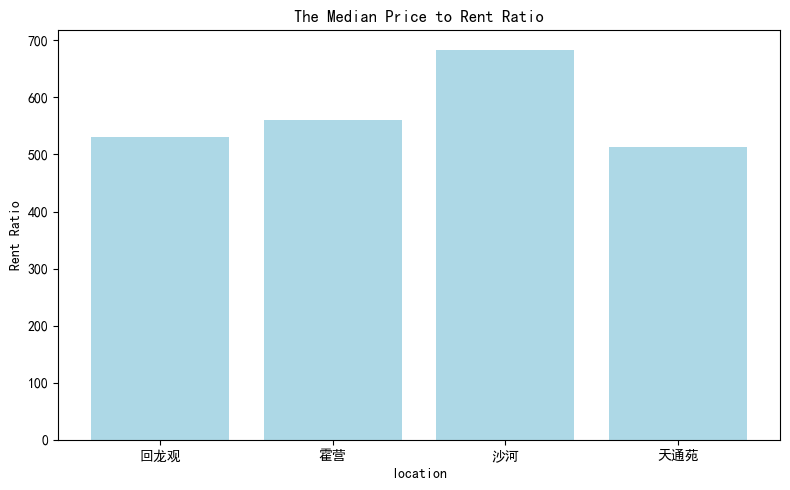

In [9]:
# Figure A绘制
for key, item in median_dict.items():
    print(f'{key} 中位数: {round(item, 2)}')

folder_path = "figures"

# 检查文件夹是否存在
if not os.path.exists(folder_path):
    os.makedirs(folder_path)  # 递归创建文件夹

# 提取名称和数值
names = list(median_dict.keys())
values = list(median_dict.values())

# 设置字体为支持中文的字体
matplotlib.rcParams['font.family'] = 'SimHei'  # 黑体
matplotlib.rcParams['axes.unicode_minus'] = False

# 绘制条形图
plt.figure(figsize=(8, 5))
plt.bar(names, values, color='lightblue')

# 添加标题和标签
plt.title('The Median Price to Rent Ratio')
plt.xlabel('location')
plt.ylabel('Rent Ratio')

# 显示图表
plt.savefig('./figures/figure_A.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()